In [84]:
from os import path
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from yass.explore import RecordingExplorer
from yass.neuralnetwork import get_nn_output, NeuralNetDetector
from yass import preprocess, detect

plt.rcParams['figure.figsize'] = (10, 10)

In [193]:
path_to_data = path.expanduser('~/data')
path_to_gold_standard = path.join(path_to_data, 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_raw = path.join(path_to_data, 'ej49_data1_set1.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

output_dir = 'tmp/'

yass.set_config(path.join(path_to_data, 'nnet/config.yaml'))

In [194]:
explorer_raw = RecordingExplorer(path_to_raw, path_to_geom,
                                 dtype='int16',
                                 n_channels=49, data_order='samples',
                                 spike_size=15, neighbor_radius=70)

explorer_std = RecordingExplorer(path_to_standarized, path_to_geom,
                                 dtype='int16',
                                 n_channels=49, data_order='samples',
                                 spike_size=15, neighbor_radius=70)

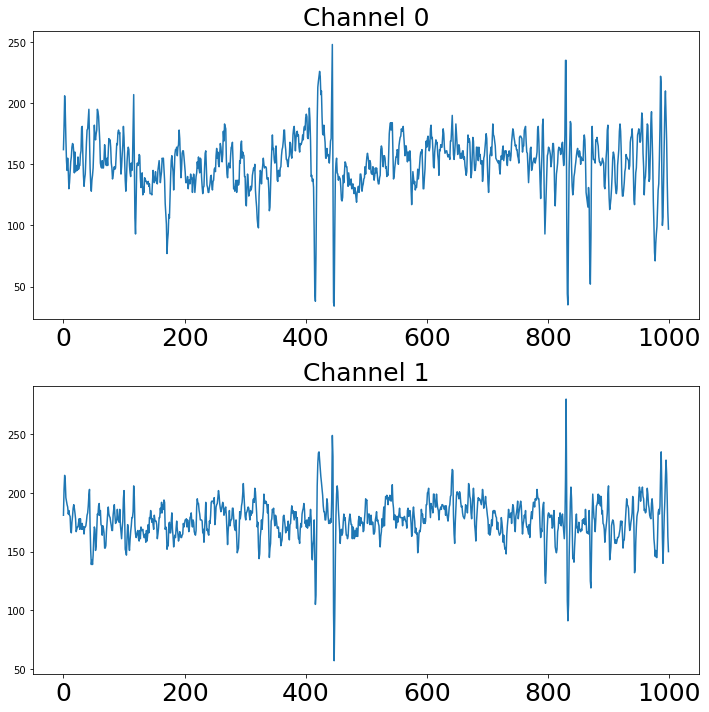

In [199]:
explorer_raw.plot_series(0, 1000, channels=[0, 1])

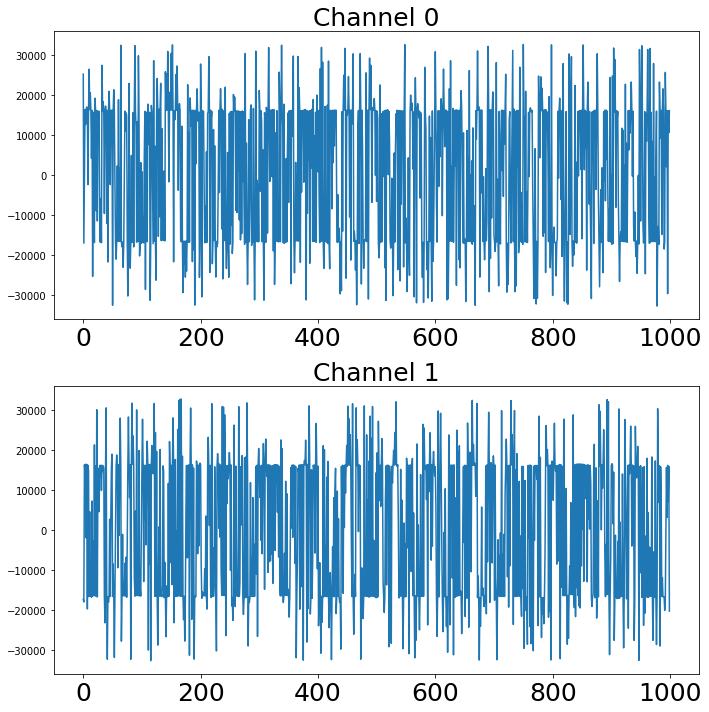

In [200]:
explorer_std.plot_series(0, 1000, channels=[0, 1])

In [176]:
def spike_amplitudes(explorer, spike_index):
    """Return amplitude for every spike
    """
    indexes = spike_index[:, 0]
    main_channels = spike_index[:, 1]
    
    spikes = np.stack([explorer.read_waveform(t, channels=[c]) for t, c in zip(indexes, main_channels)])
    spikes = spikes[:, :, 0]
    
    maxs = np.max(spikes, axis=1)
    mins = np.min(spikes, axis=1)
    
    amps = maxs - mins
    
    return amps

In [163]:
(standarized_path,
     standarized_params,
     channel_index,
     whiten_filter) = preprocess.run(output_directory=output_dir)

In [164]:
(score, spike_index_clear,
     spike_index_all) = detect.run(standarized_path,
                                   standarized_params,
                                   channel_index,
                                   whiten_filter,
                                   output_directory=output_dir)

100%|██████████| 57/57 [01:27<00:00,  1.54s/it]


In [177]:
# load gold standard
_ = loadmat(path_to_gold_standard)
gt = np.hstack([_['spt_gt'], _['L_gt']])

In [178]:
gt = gt[2:-1]

In [179]:
ids, counts = np.unique(gs[:, 1], return_counts=True)

In [180]:
f'{len(ids)} units, {len(gs):,} spikes'

'49 units, 164,409 spikes'

In [181]:
amps_all_raw = spike_amplitudes(explorer_raw, spike_index_all)
amps_clear_raw = spike_amplitudes(explorer_raw, spike_index_clear)

In [182]:
amps_all_std = spike_amplitudes(explorer_std, spike_index_all)
amps_clear_std = spike_amplitudes(explorer_std, spike_index_clear)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


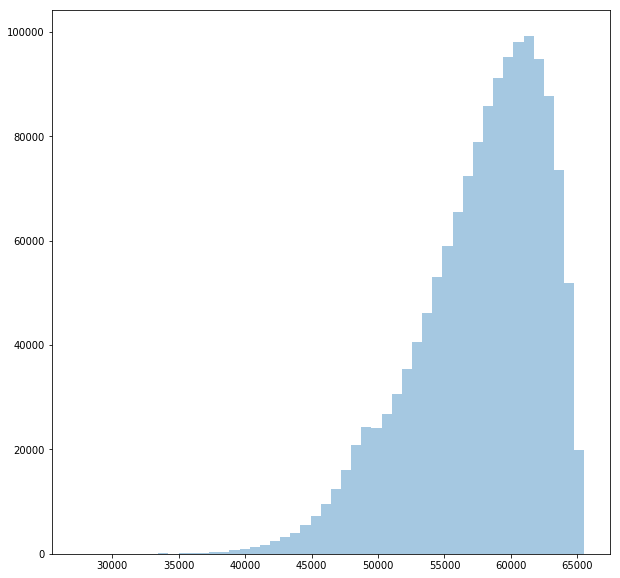

In [184]:
sns.distplot(amps_all_std, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


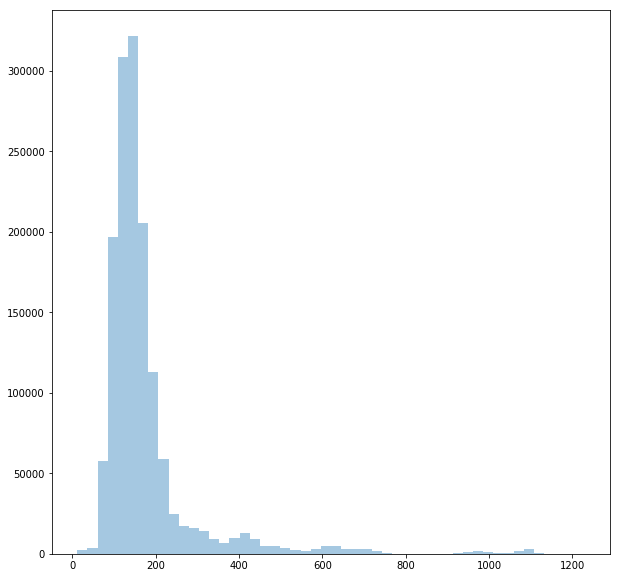

In [183]:
sns.distplot(amps_all_raw, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


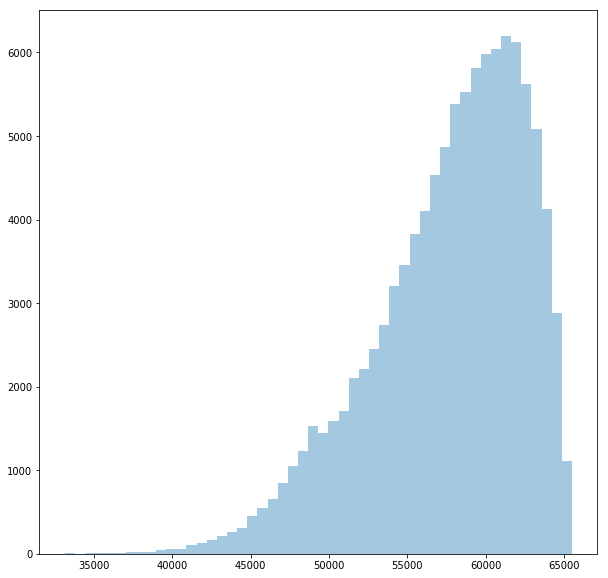

In [146]:
sns.distplot(amps_clear, kde=False)

In [156]:
wfs_gt = explorer.read_waveforms(gt[:, 0])

In [160]:
maxs = np.max(wfs_gt, axis=1)
mins = np.min(wfs_gt, axis=1)

amps_gt = maxs - mins
main_channels = np.argmax(amps_gt, axis=1)

spike_index_gs = np.vstack([gt[:, 0], main_channels]).T

amps_gt = spike_amplitudes(spike_index_gs)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


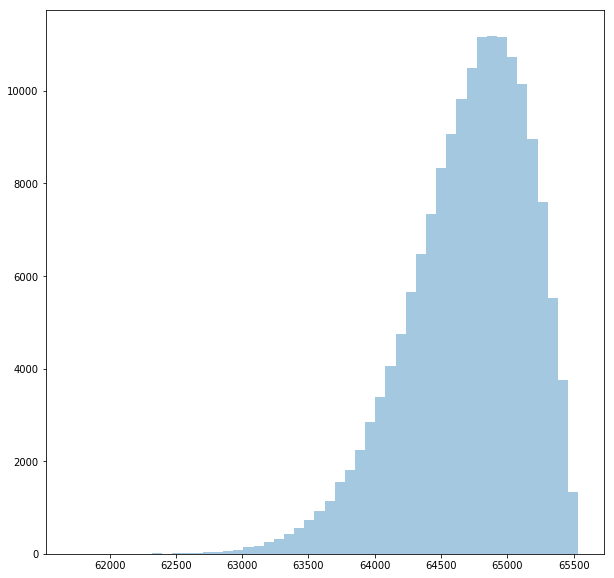

In [161]:
sns.distplot(amps_gt, kde=False)

In [85]:
import yass
from yass.geometry import make_channel_index, n_steps_neigh_channels
from yass import neuralnetwork
import tensorflow as tf

yass.set_config(path.join(path_to_data, 'nnet/config.yaml'))
CONFIG = yass.read_config()

_data = explorer.reader.data

In [116]:
data = _data[5996456-50:5996456+50, :]

In [117]:
x_tf = tf.placeholder("float", [None, None])

# load Neural Net's
detection_fname = CONFIG.detect.neural_network_detector.filename
detection_th = CONFIG.detect.neural_network_detector.threshold_spike
NND = NeuralNetDetector(detection_fname)
o_layer_tf = NND.make_o_layer_tf_tensors(x_tf,
                                         channel_index)


with tf.Session() as sess:
    NND.saver.restore(sess, NND.path_to_detector_model)

    o_layer = sess.run(
        o_layer_tf, feed_dict={x_tf: data})

In [123]:
detection_th = CONFIG.detect.neural_network_detector.threshold_spike
triage_th = CONFIG.detect.neural_network_triage.threshold_collision
detection_fname = CONFIG.detect.neural_network_detector.filename
ae_fname = CONFIG.detect.neural_network_autoencoder.filename
triage_fname = CONFIG.detect.neural_network_triage.filename

(x_tf, output_tf, NND,
 NNAE, NNT) = neuralnetwork.prepare_nn(channel_index,
                                       whiten_filter,
                                       detection_th,
                                       triage_th,
                                       detection_fname,
                                       ae_fname,
                                       triage_fname
                                       )

with tf.Session() as sess:
    # get values of above tensors
    NND.saver.restore(sess, NND.path_to_detector_model)
    NNAE.saver_ae.restore(sess, NNAE.path_to_ae_model)
    NNT.saver.restore(sess, NNT.path_to_triage_model)
    rot = NNAE.load_rotation()
    neighbors = n_steps_neigh_channels(CONFIG.neigh_channels, 2)

    (scores, clear,
         collision) = neuralnetwork.run_detect_triage_featurize(data, sess, x_tf, output_tf,
                                              neighbors,
                                              rot)

In [126]:
collision

array([[61, 36],
       [62, 47]], dtype=int32)

In [118]:
data.shape

(100, 49)

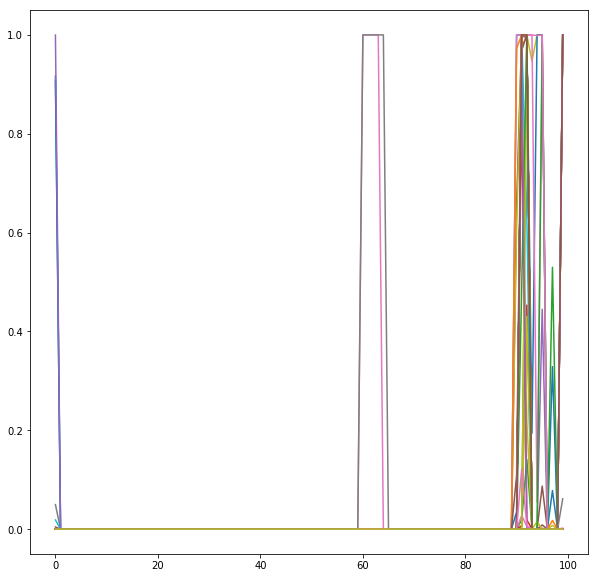

In [119]:
plt.plot(o_layer)

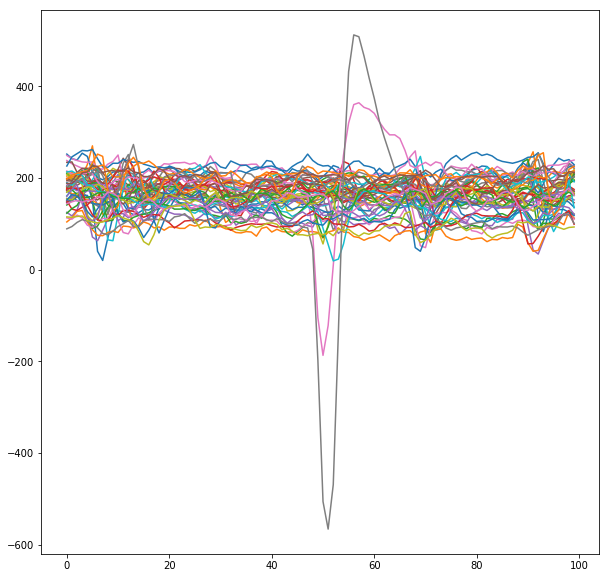

In [120]:
plt.plot(data)